## Importing Necessary Libraries
We begin by importing the necessary libraries for handling image processing, model creation, and visualization. These include TensorFlow, OpenCV, NumPy, and others.

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as pl
from sklearn.model_selection import train_test_split

dataset_path = '/kaggle/input/natural-images/natural_images/'
target_size = (256, 256)


## Data Preparation
Loading and Processing Images
The dataset consists of natural images that are resized to 256x256 pixels. We apply three different edge detection filters (Sobel, Laplacian, Prewitt) to each image.

In [2]:
# Utilize mixed precision training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')
count =0
# function to apply Sobel filter
def apply_sobel_filter(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    return cv2.magnitude(sobel_x, sobel_y)

# function to apply Laplacian filter
def apply_laplacian_filter(image):
    return cv2.Laplacian(image, cv2.CV_64F)

# function to apply Prewitt filter
def apply_prewitt_filter(image):
    kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], dtype=int)
    kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], dtype=int)
    return cv2.filter2D(image, cv2.CV_64F, kernelx) + cv2.filter2D(image, cv2.CV_64F, kernely)

# function to load and process images with all filters
def load_and_process_images_with_filters(dataset_path, target_size):
    global count
    original_images = []
    sobel_images = []
    laplacian_images = []
    prewitt_images = []

    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if count>=3000:
                return (np.expand_dims(np.array(original_images), axis=-1) / 255.0, 
            np.expand_dims(np.array(sobel_images), axis=-1) / 255.0, 
            np.expand_dims(np.array(laplacian_images), axis=-1) / 255.0,
            np.expand_dims(np.array(prewitt_images), axis=-1) / 255.0)
            
            if image is not None:
                resized_image = cv2.resize(image, target_size)
                original_images.append(resized_image)
                sobel_images.append(apply_sobel_filter(resized_image))
                laplacian_images.append(apply_laplacian_filter(resized_image))
                prewitt_images.append(apply_prewitt_filter(resized_image))
                count+=1
                
    return (np.expand_dims(np.array(original_images), axis=-1) / 255.0, 
            np.expand_dims(np.array(sobel_images), axis=-1) / 255.0, 
            np.expand_dims(np.array(laplacian_images), axis=-1) / 255.0,
            np.expand_dims(np.array(prewitt_images), axis=-1) / 255.0)

# load images with filters
original_images, sobel_images, laplacian_images, prewitt_images = load_and_process_images_with_filters(dataset_path, target_size)

X_train, X_temp, y_train_sobel, y_temp_sobel = train_test_split(original_images, sobel_images, test_size=0.3, random_state=42)
y_train_laplacian, y_temp_laplacian = train_test_split(laplacian_images, test_size=0.3, random_state=42)
y_train_prewitt, y_temp_prewitt = train_test_split(prewitt_images, test_size=0.3, random_state=42)

X_val, X_test, y_val_sobel, y_test_sobel = train_test_split(X_temp, y_temp_sobel, test_size=0.5, random_state=42)
y_val_laplacian, y_test_laplacian = train_test_split(y_temp_laplacian, test_size=0.5, random_state=42)
y_val_prewitt, y_test_prewitt = train_test_split(y_temp_prewitt, test_size=0.5, random_state=42)

# verify the split
print("Training Set Shape:", X_train.shape)
print("Validation Set Shape:", X_val.shape)
print("Test Set Shape:", X_test.shape)

Training Set Shape: (2100, 256, 256, 1)
Validation Set Shape: (450, 256, 256, 1)
Test Set Shape: (450, 256, 256, 1)


## Model Architecture
We define a convolutional neural network with a U-Net inspired architecture that includes residual connections. This architecture is utilized for each filter (Sobel, Laplacian, Prewitt).

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# for multi-GPU training
strategy = tf.distribute.MirroredStrategy()

# Model creation function (same as before, can be used for all filters)
def create_improved_filter_model(input_shape):
    with strategy.scope():
        inputs = Input(shape=input_shape)

        # Downsample
        conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
        conv1 = BatchNormalization()(conv1)
        conv1 = MaxPooling2D((2, 2))(conv1)

        conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv1)
        conv2 = BatchNormalization()(conv2)
        conv2 = MaxPooling2D((2, 2))(conv2)

        conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv2)
        conv3 = BatchNormalization()(conv3)

        # Upsample
        up1 = UpSampling2D((2, 2))(conv3)
        up1 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
        up1 = BatchNormalization()(up1)

        conv2_upsampled = UpSampling2D((2, 2))(conv2)  # Upsample conv2 to match the shape of up1
        up1 = Add()([up1, conv2_upsampled])  # Residual connection

        up2 = UpSampling2D((2, 2))(up1)
        up2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
        up2 = BatchNormalization()(up2)

        conv1_upsampled = UpSampling2D((2, 2))(conv1)  # Upsample conv1 to match the shape of up2
        up2 = Add()([up2, conv1_upsampled])  # Residual connection

        # Output layer
        outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

        model = Model(inputs, outputs)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    return model

input_shape = (256, 256, 1)

## Model Training
The models for each filter are trained and validated over 15 epochs, with a learning rate scheduler and early stopping for optimization.


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 38s 182ms/step - loss: 0.0791 - mae: 0.1789 - val_loss: 0.1395 - val_mae: 0.2320 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 169ms/step - loss: 0.0356 - mae: 0.1014 - val_loss: 0.1392 - val_mae: 0.2068 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - loss: 0.0326 - mae: 0.0921 - val_loss: 0.0972 - val_mae: 0.1769 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/step - loss: 0.0302 - mae: 0.0838 - val_loss: 0.0551 - val_mae: 0.1325 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/15
132/132 ━

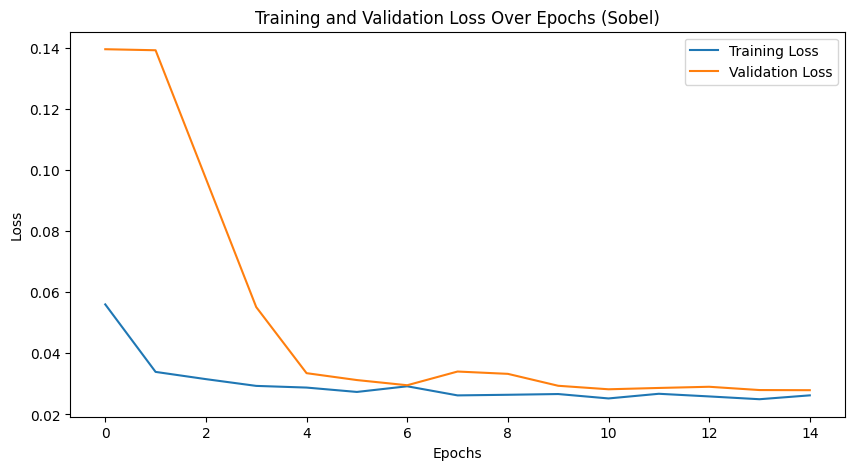

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0260 - mae: 0.0679
Sobel - Test Loss: 0.02705981582403183
Sobel - Test MAE: 0.06937748193740845
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step
Sobel - SSIM Value: 0.861656752722156

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 39s 185ms/step - loss: 0.1275 - mae: 0.2519 - val_loss: 0.0130 - val_mae: 0.0627 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 22s 168ms/step - loss: 0.0115 - mae: 0.0582 - val_loss: 0.0123 - val_mae: 0.0561 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 22s 168ms/step - loss: 0.0102 - mae: 0.0524 - val_loss: 0.0120 - val_mae: 0.0539 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/15
132/132 ━

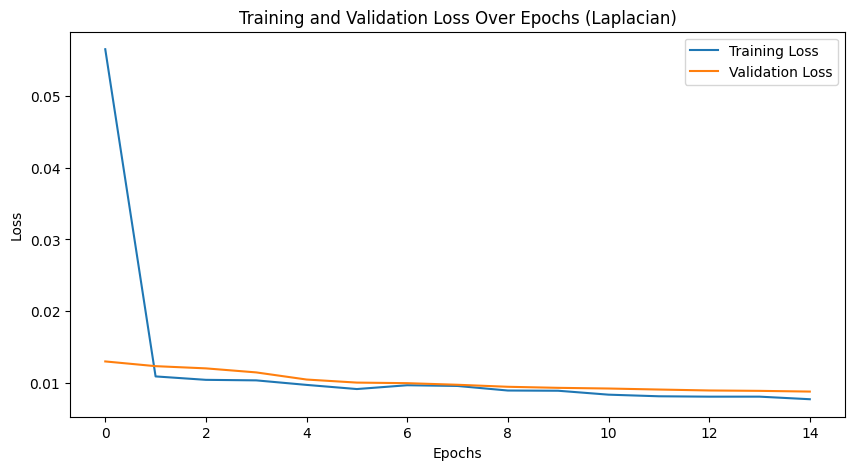

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0095 - mae: 0.0459
Laplacian - Test Loss: 0.010644162073731422
Laplacian - Test MAE: 0.04745836183428764
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step
Laplacian - SSIM Value: 0.03491246682433023

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 38s 185ms/step - loss: 0.1643 - mae: 0.2760 - val_loss: 0.1185 - val_mae: 0.1975 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 170ms/step - loss: 0.0682 - mae: 0.1364 - val_loss: 0.1086 - val_mae: 0.1897 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - loss: 0.0663 - mae: 0.1290 - val_loss: 0.0949 - val_mae: 0.1741 - learning_rate: 0.0010


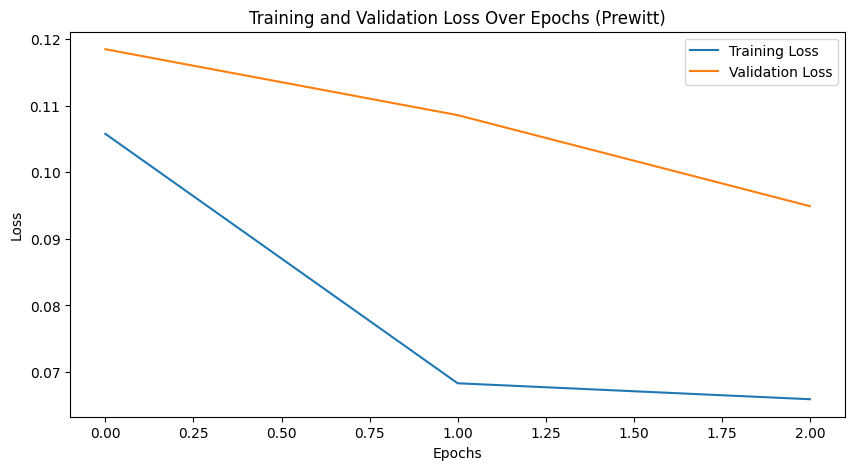

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.1161 - mae: 0.1991
Prewitt - Test Loss: 0.11792424321174622
Prewitt - Test MAE: 0.19946470856666565
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step
Prewitt - SSIM Value: 0.003202910270155964


In [10]:
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 5
    if epoch % decay_step == 0 and epoch:
        return lr * np.exp(-decay_rate)
    return lr

lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


models_dict = {}

for filter_name, y_train, y_val, y_test in [('Sobel', y_train_sobel, y_val_sobel, y_test_sobel), 
                                            ('Laplacian', y_train_laplacian, y_val_laplacian, y_test_laplacian), 
                                            ('Prewitt', y_train_prewitt, y_val_prewitt, y_test_prewitt)]:
    model = create_improved_filter_model(input_shape)
    history = model.fit(
        X_train, y_train,
        epochs=15,
        validation_data=(X_val, y_val),
        batch_size=16,
        callbacks=[lr_callback, early_stopping]
    )
    models_dict[filter_name] = model

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss Over Epochs ({filter_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate the model on the test set
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f"{filter_name} - Test Loss: {test_loss}")
    print(f"{filter_name} - Test MAE: {test_mae}")

    # Calculate SSIM for a sample image
    index = 0
    y_pred = model.predict(X_test)
    ssim_value = ssim(y_test[index].squeeze(), y_pred[index].squeeze(), data_range=1.0)
    print(f"{filter_name} - SSIM Value: {ssim_value}")

# Save the models for further use
for filter_name, model in models_dict.items():
    model.save(f'{filter_name}_filter_model.h5')

## Visualisation

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import Model

# function to get feature maps from a specific layer
def get_feature_maps(model, layer_name, input_image):
    layer = model.get_layer(name=layer_name)# Get the layer
    feature_map_model = Model(inputs=model.input, outputs=layer.output)# Create a model that outputs the feature maps of the specified layer
    feature_maps = feature_map_model.predict(input_image)# Predict feature maps for the input image

    return feature_maps

# function to plot feature maps
def plot_feature_maps(feature_maps, layer_name):
    num_feature_maps = feature_maps.shape[-1]  # number of feature maps
    size = feature_maps.shape[1]  # size of each feature map (assuming square)
    
    num_cols = 8 # number of rows and columns in the grid
    num_rows = (num_feature_maps // num_cols) + (num_feature_maps % num_cols != 0)
    
    plt.figure(figsize=(num_cols * 2, num_rows * 2))
    
    for i in range(num_feature_maps):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.axis('off')
    
    plt.suptitle(f'Feature Maps of Layer: {layer_name}')
    plt.show()

def visualize_layer_features(model, layer_name, img_path):
    img = image.load_img(img_path, target_size=(256, 256), color_mode='grayscale')
    input_image = image.img_to_array(img)
    input_image = np.expand_dims(input_image, axis=0)

    feature_maps = get_feature_maps(model, layer_name, input_image)
    plot_feature_maps(feature_maps, layer_name)

layer_names = ['conv2d_12', 'batch_normalization_10', 'conv2d_13', 'batch_normalization_11', 
               'conv2d_14', 'batch_normalization_12', 'conv2d_15', 'batch_normalization_13', 
               'conv2d_16', 'batch_normalization_14', 'conv2d_17']  
img_path = '/kaggle/input/testimg/testimg.jpg' 


for layer_name in layer_names:
    visualize_layer_features(model, layer_name, img_path)


SyntaxError: invalid syntax (1375150572.py, line 40)